In [2]:
import os
import sys

import matplotlib.pyplot as plt
from hydra import compose, initialize
    
import math
import torch
import torch.nn as nn

import pytorch_lightning as lightning
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint 

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

In [3]:
torch.cuda.empty_cache()

In [4]:
"""config"""

initialize(version_base=None, config_path="", job_name="lds")
cfg = compose(config_name="config")
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1234


In [5]:
"""generate data -- 2d oscillator with decay"""

n_trials = 500
n_neurons = 100
n_time_bins = 250

C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device).requires_grad_(False)
Q_diag = 1e-3 * torch.ones(cfg.n_latents, device=cfg.device)
Q_0_diag = 2. * torch.ones(cfg.n_latents, device=cfg.device)
R_diag = 1e-1 * torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

mean_fn = utils.VdpDynamicsModel()

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()

y_train, z_train = y[:2*n_trials//3], z[:2*n_trials//3]
y_valid, z_valid = y[2*n_trials//3:], z[2*n_trials//3:]

In [6]:
y_train_dataset = torch.utils.data.TensorDataset(y_train,)
y_valid_dataset = torch.utils.data.TensorDataset(y_valid,)

train_dataloader = torch.utils.data.DataLoader(
    y_train_dataset,
    batch_size=cfg.batch_sz,
    shuffle=True,
    num_workers=9
)

valid_dataloader = torch.utils.data.DataLoader(
    y_valid_dataset,
    batch_size=cfg.batch_sz,
    shuffle=True,
)

In [7]:
"""likelihood pdf"""

likelihood_pdf = GaussianLikelihood(C, n_neurons, R_diag, device=cfg.device)

In [8]:
"""dynamics module"""

dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

In [9]:
"""initial condition"""

initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

In [10]:
"""local/backward encoder"""

backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)

local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents, rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)

nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

In [11]:
"""sequence vae"""

ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

In [12]:
"""lightning"""

seq_vae = LightningNonlinearSSM(ssm, cfg)

In [13]:
csv_logger = CSVLogger('logs/', name=f'r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='noncausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='valid_loss', mode='min', dirpath='ckpts/',
                                filename='{epoch:0}_{valid_loss}')

In [14]:
trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger
                            )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/best_model_path.pt')

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/r_y_2_r_b_2/noncausal exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/mahmoud/catnip/xfads/workshop/vanderpool/ckpts exists and is not empty.

  | Name | Type                            | Params
---------------------------------------------------------
0 | ssm  | LowRankNonlinearStateSpaceModel | 41.3 K
---------------------------------------------------------
41.0 K    Trainable params
300       Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [16]:
trainer.test(dataloaders=valid_dataloader, ckpt_path='last')

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.


MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.

In [29]:
"""lightning"""

seq_vae = LightningNonlinearSSM.load_from_checkpoint(torch.load(f'ckpts/best_model_path.pt'), ssm=ssm, cfg=cfg)

IsADirectoryError: [Errno 21] Is a directory: '/Users/mahmoud/catnip/xfads/workshop/vanderpool/'

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_5863/2867661776.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_5863/2867661776.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


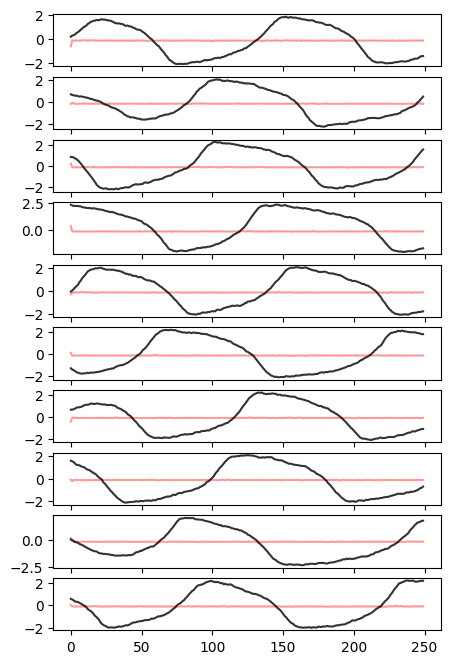

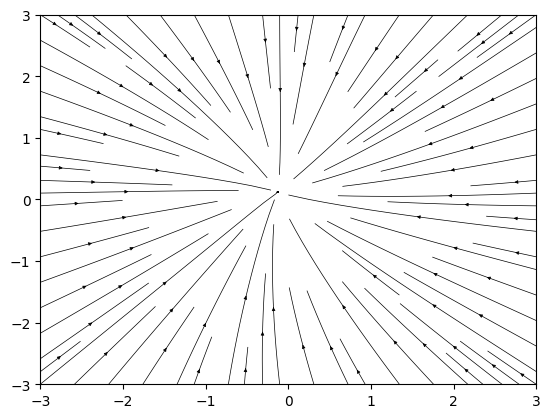

In [21]:
loss, z, stats = seq_vae.ssm(y_valid, cfg.n_samples)

n_ex = 10

fig, axs = plt.subplots(n_ex, 1, figsize=(5, 8))

[axs[i].plot(stats['m_f'][i, :, 0].detach().numpy(), color='red', alpha=0.4) for i in range(n_ex)]
[axs[i].plot(z_valid[i, :, 0].detach().numpy(), color='black', alpha=0.8) for i in range(n_ex)]

fig.show()

fig, axs = plt.subplots()
plot_utils.plot_two_d_vector_field(seq_vae.ssm.dynamics_mod.mean_fn, axs)
fig.show()